## Variational autoencoder

От классических механизмов генерации последовательностей автоэнкодерами этот отличается использованием сверток вместо рекуррентных слоев. В скрытом пространстве отчетливо наблюдается 2 распределения. Музыкально фрагменты из этих распределений всегда отличались.

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append('src/')
from models.vae import MusicVAE
from save_midi import save_notes_and_durations
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
len(notes), len(set(notes))

(16050, 310)

In [5]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [6]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [7]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)    
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    sequences = [note_sequences[indicies], dur_sequences[indicies]]
    targets = [note_targets, dur_targets]
    return sequences, targets

In [8]:
X, y = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(15456, 128)

In [9]:
y[0].shape

(15456, 128, 150)

In [10]:
model = MusicVAE(
    kernel_size = 32,
    encoder_filters = [128, 128, 64, 32],
    encoder_strides = [1, 2, 2, 1],
    decoder_filters = [128, 128, 128, 128],
    decoder_strides = [1, 2, 2, 1],
    n_notes = len(note_dictionary),
    n_durations = len(duration_dictionary),
    emb_size = 64,
    input_dim = X[0].shape[1],
    latent_dim = 2,
    loss_factor = 500
)

In [11]:
model.compile(0.0003)

In [17]:
model.model.fit(
    X, y,
    shuffle=True,
    batch_size=32,
    epochs=15
)

Epoch 1/15
483/483 [==============================] - 82s 170ms/step - cce_notes: 1361.3249 - cce_durations: 535.9255 - kl: 10.7132 - loss: 1907.9636
Epoch 2/15
483/483 [==============================] - 85s 176ms/step - cce_notes: 1346.7200 - cce_durations: 532.9710 - kl: 10.4927 - loss: 1890.1838
Epoch 3/15
483/483 [==============================] - 83s 173ms/step - cce_notes: 1342.0895 - cce_durations: 530.5035 - kl: 10.5548 - loss: 1883.1478
Epoch 4/15
483/483 [==============================] - 83s 173ms/step - cce_notes: 1331.9421 - cce_durations: 527.5489 - kl: 10.6452 - loss: 1870.1361
Epoch 5/15
483/483 [==============================] - 81s 168ms/step - cce_notes: 1326.9190 - cce_durations: 526.5687 - kl: 10.8003 - loss: 1864.2880
Epoch 6/15
483/483 [==============================] - 82s 170ms/step - cce_notes: 1315.5848 - cce_durations: 523.1203 - kl: 10.8463 - loss: 1849.5515
Epoch 7/15
483/483 [==============================] - 81s 168ms/step - cce_notes: 1315.2182 - cce_du

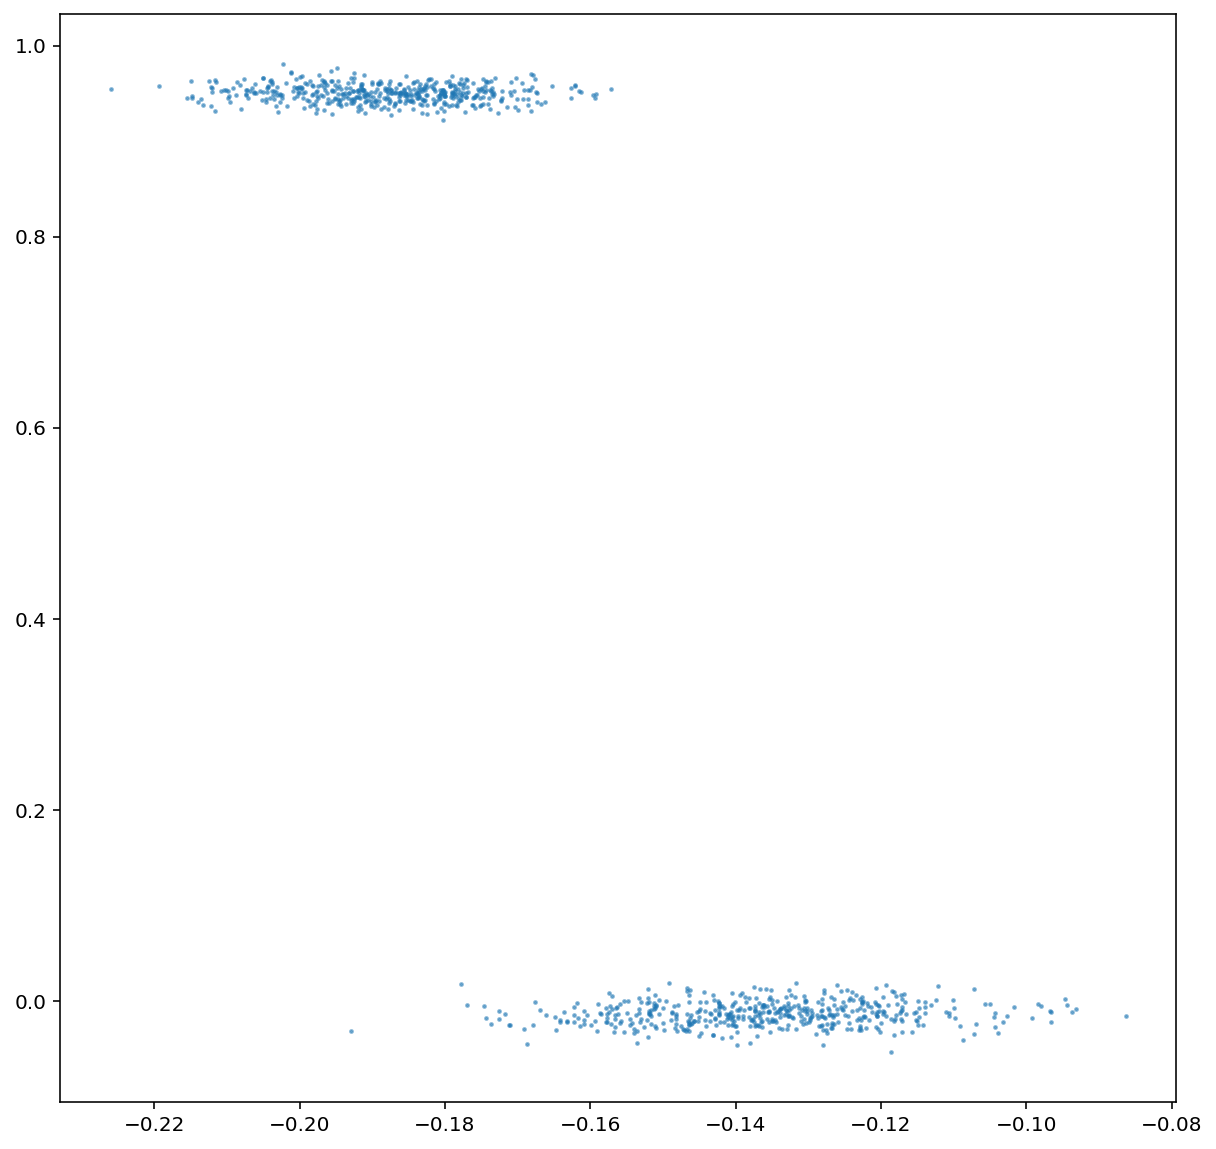

In [18]:
example_idx = np.random.choice(range(len(X)), 1000)
example_states = [X[0][example_idx], X[1][example_idx]]

_, _, z_points = model.encoder.predict(example_states)

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.show()

In [19]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [21]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_notes = []
    generated_durations = []
    predicted_notes, predicted_durations = model.decoder.predict(np.array([[-0.2, 0.95]]))
    for i in range(predicted_notes.shape[1]):
        generated_notes.append(sample(predicted_notes[0][i], temperature))
        generated_durations.append(sample(predicted_durations[0][i], temperature))
        
    generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]
    save_notes_and_durations(generated, f'output/vae/output_{temperature}_top')